In [1]:
import pandas as pd

import argparse
from time import time

from datasets import load_from_disk
from peft import LoraConfig, get_peft_model
from torch.utils.data import DataLoader
from transformers import AutoModelForCausalLM, Trainer, TrainingArguments
from utils_dev import *

from concrete.ml.torch.hybrid_model import HybridFHEMode
from concrete.ml.torch.lora import LoraTrainer

/Users/kcelia/Zama/concrete-ml/use_case_examples/hybrid_finetuning_of_llama/.venv_llama/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Hybrid Fine-Tuning of LLaMA with LoRA

This notebook showcases how to fine-tune the LLaMA-3.2-1B model using LoRA (Low-Rank Adaptation) on the Orca Math Word Problems dataset. The fine-tuning is performed using the _HybridModel_ paradigm, which enables a seamless separation of the computational workload of large language models between the client and a remote server.

To preserve data privacy while maintaining performance, this hybrid setup leverages Fully Homomorphic Encryption (FHE) on the remote side. The execution pipeline is structured as follows:

- Remote linear layers — which account for the majority of the model's weights and computational cost — are offloaded to a distant machine and executed under encryption using FHE.
- Local non-linear layers — such as activation functions — are retained on-premise and executed in plaintext on the client side.
- The client’s dataset remains strictly local and is never transferred externally.

This approach allows for privacy-preserving fine-tuning and inference, while reducing the computational burden on the client and ensuring that sensitive data never leaves the local environment.

In [14]:
PEFT_ARGS = {
    "r": 8,
    "lora_alpha": 32,
    "lora_dropout": 0.1,
    "bias": "none",
    "task_type": "CAUSAL_LM",
    "target_modules": "all-linear",
}

TRAINING_ARGS = {
    "output_dir": "./checkpoints",
    "num_train_epochs": 1,
    "per_device_train_batch_size": 1,
    "gradient_accumulation_steps": 1,
    "save_total_limit": 1,
    "use_cpu": True,
    "learning_rate": 2e-4,
    "lr_scheduler_type": "linear",
    "seed": SEED,
    "data_seed": SEED,
    "warmup_steps": 10,
    "weight_decay": 0.01,
    "prediction_loss_only": True,
    "report_to": "none",
}

URL = "http://15.237.83.254:8001"

DEVICE = get_device(force_device='cpu')

## Load data

The question-answer dataset has been preprocessed and filtered in the `processed_data.py` script and saved to disk for convenience. We load it here directly to simplify the fine-tuning workflow.

> ⚠️ If the files are missing, please run `processed_data.py` to regenerate them.


In [3]:
collator = DataCollator(TOKENIZER)
train_dataset = load_from_disk(TRAIN_PATH)
test_dataset = load_from_disk(TEST_PATH)

## Load Model and Tokenizer

Load the LLaMA model and tokenizer, and test the base model output.

In [4]:
pretrained_model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, token=HF_TOKEN).to(DEVICE)
pretrained_model.config.pad_token_id = pretrained_model.config.eos_token_id

for param in pretrained_model.parameters():
    param.requires_grad = False

PROMPT = "When you multiply a number by 7, it becomes 98. What is that number?\n"
_ = generate_and_print(PROMPT, pretrained_model, TOKENIZER, seed=SEED)

Prompt: `When you multiply a number by 7, it becomes 98. What is that number?
`
Response: `A. 0
B. 1
C. 2
D. 3
E. 4
Answer: B`



## LoRA Configuration

Set up LoRA parameters and apply them to the model.

In [5]:
peft_model = get_peft_model(pretrained_model, LoraConfig(**PEFT_ARGS)).to(DEVICE)

## Training Arguments

Configure the training hyperparameters.

In [ ]:
hf_trainer = Trainer(
    model=peft_model,
    args=TrainingArguments(**TRAINING_ARGS),
    train_dataset=train_dataset,
    data_collator=collator,
)

train_dl = hf_trainer.get_train_dataloader()
eval_dl = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collator)

hf_trainer.create_optimizer_and_scheduler(len(train_dl) * TRAINING_ARGS["num_train_epochs"])
optimizer, lr_scheduler = hf_trainer.optimizer, hf_trainer.lr_scheduler


lora_trainer = LoraTrainer(
    model=peft_model,
    optimizer=optimizer,
    loss_fn=causal_lm_loss,
    lr_scheduler=lr_scheduler,
    training_args=TRAINING_ARGS,
    n_layers_to_skip_for_backprop=3,
    eval_loader=eval_dl,
    eval_metric_fn=metric_fn,
    logging_steps=1,
    eval_steps=100,
    train_log_path=TRAIN_LOG_FILE,
    machine_type="M4",
    server_remote_address=URL,
    model_name=f"meta-llama",
)


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


2025-07-16 09:54:47,094 - INFO - === Starting new training session ===
2025-07-16 09:54:47,098 - INFO - Processing '5' Remote Modules.
2025-07-16 09:54:47,100 - INFO - Benchmark file created: '/Users/kcelia/Zama/concrete-ml/use_case_examples/hybrid_finetuning_of_llama/client_benchmarks.csv'


LoRA layers detected in the model.


## Compilation

In [7]:
inputset = get_random_inputset(
        vocab_size=VOCAB_SIZE, batch_size=BATCH_SIZE, max_length=MAX_LENGTH, device=DEVICE
    )
start_time = time()
lora_trainer.compile(inputset, n_bits=N_BITS, device=DEVICE)
print(f"Compilation completed under: {time() - start_time:.2f}s using {DEVICE=}")

Compiling FHE layers: 100%|██████████| 5/5 [00:00<00:00,  6.51it/s]
2025-07-16 09:54:55,944 - INFO - Compilation complete.


Compilation completed under: 3.61s using DEVICE='cpu'


# Evaluate the model before fine-tuning

In [8]:
peft_model.eval()

initial_weights = extract_lora_weights(peft_model)

initial_metrics = metric_fn(peft_model, eval_dl, PROMPT, EVAL_RESPONSES_FILE, DEVICE)
print(f"Final perplexity after extended training: {initial_metrics['perplexity']:.2f}")

Prompt: `When you multiply a number by 7, it becomes 98. What is that number?
`
Response: `A. 0
B. 1
C. 2
D. 3
E. 4
Answer: B`



Final perplexity after extended training: 116.61


## Separate Remote Modules

In a hybrid execution setup, we must isolate the parts of the model that will run remotely (typically, the linear layers) from those that will stay on the client side (non-linear layers, activations, etc.).

The following line performs this separation by:

- Saving the compiled remote modules (linear layers quantized and ready for remote execution),
- Removing sensitive information such as calibration data or client-side metadata,


In [10]:
lora_trainer.save_and_clear_private_info(COMPILED_MODELS_PATH, via_mlir=True)

2025-07-16 09:55:58,924 - INFO - Model saved at compiled_models/meta-llama


## Initialize Client-Side Model

Here we generate keys and send the public evaluation key to the server.

In [60]:
client_path = COMPILED_MODELS_PATH / "client"

lora_trainer.hybrid_model.init_client(
    path_to_clients=client_path, path_to_keys=PATH_TO_CLIENTS_KEYS
)

# Enable remote FHE mode: linear layers will be executed on the server
lora_trainer.hybrid_model.set_fhe_mode(HybridFHEMode.REMOTE)

2025-07-16 12:06:38,231 - INFO - All remote modules initialized.


## Run a Short Fine-Tuning Loop with Remote FHE

We fine-tune the model for a few batches using remote FHE mode:

In [12]:
limited_batches = get_limited_batches(train_dl, 3)
lora_trainer.train(limited_batches, fhe="remote", device=DEVICE)

Epoch 1:   0%|          | 0/3 [00:00<?, ?it/s]2025-07-16 09:56:57,125 - INFO - Starting inference for module name: 'inference_model.base_model.model.model.layers.0.self_attn.q_proj.base_layer'...
2025-07-16 09:57:04,326 - INFO - Starting inference for module name: 'inference_model.base_model.model.model.layers.0.self_attn.k_proj.base_layer'...
2025-07-16 09:57:08,617 - INFO - Starting inference for module name: 'inference_model.base_model.model.model.layers.0.self_attn.v_proj.base_layer'...
2025-07-16 09:57:13,068 - INFO - Starting inference for module name: 'inference_model.base_model.model.model.layers.0.self_attn.o_proj.base_layer.forward_module'...
2025-07-16 09:57:21,654 - INFO - Starting inference for module name: 'inference_model.base_model.model.model.layers.0.self_attn.o_proj.base_layer.backward_module'...
2025-07-16 09:57:29,232 - INFO - Step 1: loss=2.042863, avg_loss=2.042863
2025-07-16 09:57:29,236 - INFO - Average gradient magnitude: 1.105630
Epoch 1:  33%|███▎      | 1/3

# Evaluate the model after fine-tuning

We evaluate the model on the validation set to compute its final perplexity, a standard metric for language modeling:

In [13]:

finetuned_weights = extract_lora_weights(peft_model)
peft_model.eval()
metrics_final = metric_fn(peft_model, eval_dl, PROMPT, EVAL_RESPONSES_FILE, DEVICE)
print(f"Final perplexity after extended training: {metrics_final['perplexity']:.2f}")

2025-07-16 10:16:09,668 - INFO - Starting inference for module name: 'inference_model.base_model.model.model.layers.0.self_attn.q_proj.base_layer'...
2025-07-16 10:16:15,320 - INFO - Starting inference for module name: 'inference_model.base_model.model.model.layers.0.self_attn.k_proj.base_layer'...
2025-07-16 10:16:20,192 - INFO - Starting inference for module name: 'inference_model.base_model.model.model.layers.0.self_attn.v_proj.base_layer'...
2025-07-16 10:16:23,498 - INFO - Starting inference for module name: 'inference_model.base_model.model.model.layers.0.self_attn.o_proj.base_layer.forward_module'...
2025-07-16 10:16:28,829 - INFO - Starting inference for module name: 'inference_model.base_model.model.model.layers.0.self_attn.q_proj.base_layer'...
2025-07-16 10:16:29,431 - INFO - Starting inference for module name: 'inference_model.base_model.model.model.layers.0.self_attn.k_proj.base_layer'...
2025-07-16 10:16:29,847 - INFO - Starting inference for module name: 'inference_model

Prompt: `When you multiply a number by 7, it becomes 98. What is that number?
`
Response: `When you multiply a number by 7, it becomes 98. What is that number?
The number 98 is the answer to the multiplication problem`



Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]2025-07-16 10:17:32,563 - INFO - Starting inference for module name: 'inference_model.base_model.model.model.layers.0.self_attn.q_proj.base_layer'...
2025-07-16 10:17:48,310 - INFO - Starting inference for module name: 'inference_model.base_model.model.model.layers.0.self_attn.q_proj.base_layer'...
2025-07-16 10:17:55,600 - INFO - Starting inference for module name: 'inference_model.base_model.model.model.layers.0.self_attn.q_proj.base_layer'...
2025-07-16 10:18:02,758 - INFO - Starting inference for module name: 'inference_model.base_model.model.model.layers.0.self_attn.q_proj.base_layer'...
2025-07-16 10:18:09,870 - INFO - Starting inference for module name: 'inference_model.base_model.model.model.layers.0.self_attn.k_proj.base_layer'...
2025-07-16 10:18:14,371 - INFO - Starting inference for module name: 'inference_model.base_model.model.model.layers.0.self_attn.k_proj.base_layer'...
2025-07-16 10:18:18,748 - INFO - Starting inferenc

Final perplexity after extended training: 15.75


In [59]:
def generate_and_print(prompt, model, tokenizer, seed=None, max_new_tokens=30):
    """
    Generates text based on the provided prompt and prints both the prompt and the generated text.

    Args:
        prompt (str): The input prompt to generate text from.
        model: The pre-trained language model.
        tokenizer: The tokenizer associated with the model.
        seed (int, optional): Seed for random number generators to ensure reproducibility.
        max_new_tokens (int, optional): Maximum number of tokens to generate. Defaults to 30.
    Returns:
        str: The generated text (response only, without the prompt).
    """
    try:
        # Set the environment variable for CuBLAS deterministic behavior
        os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

        # Set the random seed for reproducibility
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)
            torch.manual_seed(seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed_all(seed)

        # Encode the input prompt
        inputs = tokenizer.encode_plus(prompt, return_tensors="pt")

        # Move inputs to the same device as the model
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        # Generate text
        with torch.no_grad():
            output = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_new_tokens=max_new_tokens,
                top_p=0.9,
                temperature=0.6,
                do_sample=True,
                pad_token_id=tokenizer.eos_token_id,
            )

        # Get only the newly generated tokens
        input_length = inputs["input_ids"].shape[1]
        generated_ids = output[0, input_length:]
        generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()

        # Print the prompt and generated text
        print(f"Prompt: `{prompt}`")
        print(f"Response: `{generated_text}`\n")

        return generated_text

    except Exception as e:
        print(f"Error in generation: {str(e)}")
        return None


response = generate_and_print(PROMPT, peft_model, TOKENIZER, seed=SEED)

2025-07-16 12:06:05,235 - INFO - Starting inference for module name: 'inference_model.base_model.model.model.layers.0.self_attn.q_proj.base_layer'...


Error in generation: 


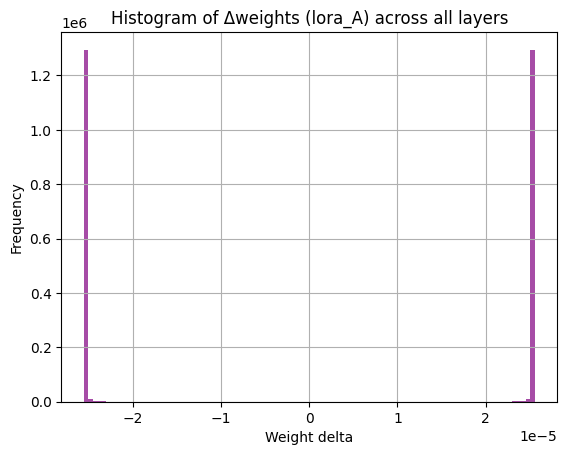

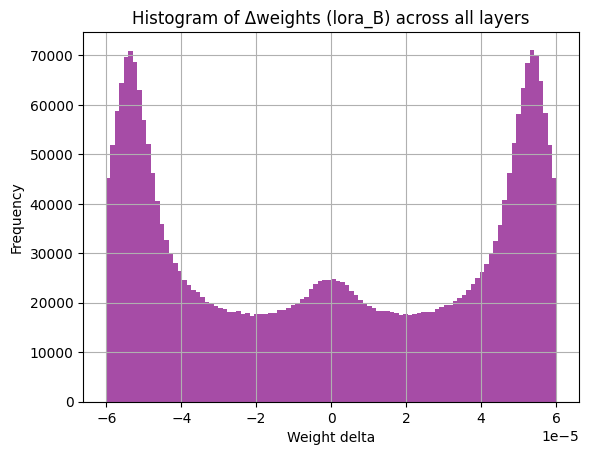

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_lora_weight_differences(initial_dict, finetuned_dict, pattern='lora_A'):
    """
    A: reduction matrix (dim → r)
    B: reconstruction matrix (r → dim)
    """
    diffs = []
    cosin = []
    for k in initial_dict:
        if pattern in k:
            init = initial_dict[k]
            ft = finetuned_dict[k]
            diff = ft - init


            diffs.extend(diff.flatten())

    diffs = np.array(diffs)
    plt.hist(diffs, bins=100, alpha=0.7, color='purple')
    plt.title(f"Histogram of Δweights ({pattern}) across all layers")
    plt.xlabel("Weight delta")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

plot_lora_weight_differences(initial_weights, finetuned_weights, pattern='lora_A')
plot_lora_weight_differences(initial_weights, finetuned_weights, pattern='lora_B')


In [63]:
len(initial_weights)

224

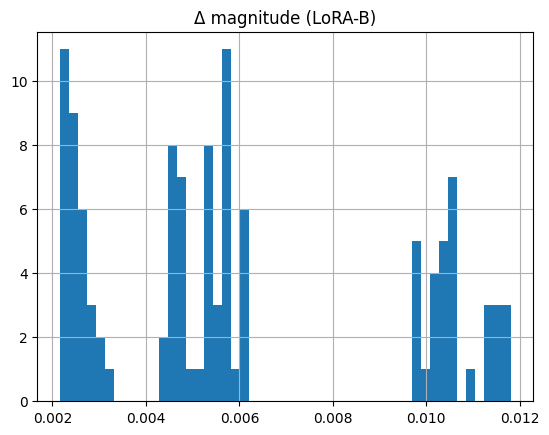

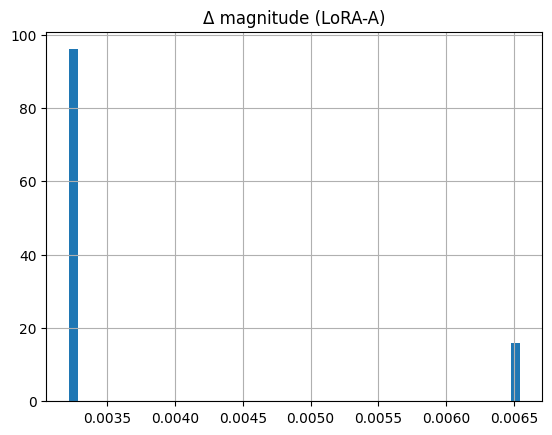

In [85]:
import torch, torch.nn.functional as F, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

def collect_stats(init_w, ft_w):
    """
    - How much it has changed (delta amplitude),
    - In which direction it has changed (cosine similarity),
    - How significant the change is compared to the initial scale.
    """

    rows = []
    for k, w_init in init_w.items():
        if "lora_" not in k:
            continue
        w_ft   = ft_w[k]
        w_init = torch.from_numpy(w_init)
        w_ft   = torch.from_numpy(w_ft)

        delta  = (w_ft - w_init).flatten()
        part   = "A" if "lora_A" in k else "B"
        # This gives an absolute measure of the amplitude of change.
        l2     = torch.norm(delta).item()
        # safe cosine (avoid zero division)
        cos = 0.0
        # This measures the directional alignment between the 2 matrices.
        # cos(θ) ≈ 1 ⇒ fine-tuning has just changed the amplitude, not the direction.
        # cos(θ) < 1 ⇒ weight rotation ⇒ structural change in layer behavior
        if torch.norm(w_init) > 0 and torch.norm(w_ft) > 0:
            cos = F.cosine_similarity(w_init.flatten(), w_ft.flatten(), dim=0).item()

        rows.append(dict(layer=k, part=part, L2=l2, cos=cos))
    return pd.DataFrame(rows)

df = collect_stats(initial_weights, finetuned_weights)

# Δ distribution LoRA-B
df.query("part=='B'")["L2"].hist(bins=50); plt.title("Δ magnitude (LoRA-B)"); plt.show()
df.query("part=='A'")["L2"].hist(bins=50); plt.title("Δ magnitude (LoRA-A)"); plt.show()

# # Cosine heatmap LoRA-A
# pivot = df.query("part=='A'").pivot_table(index="layer", values="cos")
# plt.imshow(pivot, cmap="coolwarm", aspect="auto", vmin=-1, vmax=1)
# plt.colorbar(); plt.title("Cosine similarity LoRA-A"); plt.ylabel("Layer"); plt.show()

## Benchmark

In [57]:
!curl -o server_benchmarks.csv "{URL}/download_benchmark"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100  152k  100  152k    0     0   344k      0 --:--:-- --:--:-- --:--:--  344k


In [16]:
client = pd.read_csv("client_benchmarks.csv", sep=";")
server = pd.read_csv("server_benchmarks.csv", sep=";")

In [17]:
server.head(5)

,endpoint,date,device,machine,uid,layer_name,index,input_shape,remote_weight_shape,time_read_key,time_deserialization_key,time_serialization_key,time_storage_key,time_read_input,time_deserialize_input,encrypted_input_size,time_weight_quantization,time_serialization_output,time_matmul,time_packing_output_response,total_add_key_func,total_compute_func
0,Key,2025-07-16 07:56:57,cuda,g4dn.16xlarge,8285e582-cf61-4254-9a19-932ecd98e973,NaN,NaN,NaN,NaN,0.039,0.289307,0.095394,0.232877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.562782,NaN
1,compute,2025-07-16 07:57:03,cuda,g4dn.16xlarge,8285e582-cf61-4254-9a19-932ecd98e973,inference_model.base_model.model.model.layers....,0.0,"(64, 2048)","(2048, 2048)",NaN,NaN,NaN,NaN,0.000337,0.000715,530968.0,0.142085,0.000933,5.805625,0.000280,NaN,6.043856
2,compute,2025-07-16 07:57:08,cuda,g4dn.16xlarge,8285e582-cf61-4254-9a19-932ecd98e973,inference_model.base_model.model.model.layers....,1.0,"(64, 2048)","(2048, 512)",NaN,NaN,NaN,NaN,0.000287,0.000254,530968.0,0.002871,0.000273,3.084534,0.000112,NaN,3.121882
3,compute,2025-07-16 07:57:12,cuda,g4dn.16xlarge,8285e582-cf61-4254-9a19-932ecd98e973,inference_model.base_model.model.model.layers....,2.0,"(64, 2048)","(2048, 512)",NaN,NaN,NaN,NaN,0.000299,0.000493,530968.0,0.002543,0.000233,3.069476,0.000121,NaN,3.105486
4,compute,2025-07-16 07:57:19,cuda,g4dn.16xlarge,8285e582-cf61-4254-9a19-932ecd98e973,inference_model.base_model.model.model.layers....,3.0,"(64, 2048)","(2048, 2048)",NaN,NaN,NaN,NaN,0.000282,0.000483,530968.0,0.007709,0.000687,5.795685,0.000141,NaN,5.907527


In [18]:
client.head(5)

,date,device,machine,uid,server_remote_address,layer_name,input_shape,remote_weight_shape,time_encryption_input,time_serialization_input,total_send_input_func,time_deserialization_output,time_decryption_output,time_dequantization_output,total_compute_func,total_timing
0,2025-07-16 09:57:04,cpu,M4,8285e582-cf61-4254-9a19-932ecd98e973,http://15.237.83.254:8001,remote_weights_layer0.npy,"(64, 2048)","(2048, 2048)",0.022629,0.000124,NaN,0.000243,0.022474,0.001219,6.743744,7.199026
1,2025-07-16 09:57:08,cpu,M4,8285e582-cf61-4254-9a19-932ecd98e973,http://15.237.83.254:8001,remote_weights_layer1.npy,"(64, 2048)","(2048, 512)",0.022372,0.000121,NaN,0.000347,0.022914,0.000459,3.815817,4.286619
2,2025-07-16 09:57:13,cpu,M4,8285e582-cf61-4254-9a19-932ecd98e973,http://15.237.83.254:8001,remote_weights_layer2.npy,"(64, 2048)","(2048, 512)",0.026461,0.000091,NaN,0.000256,0.022851,0.000319,3.954101,4.450253
3,2025-07-16 09:57:20,cpu,M4,8285e582-cf61-4254-9a19-932ecd98e973,http://15.237.83.254:8001,remote_weights_layer3.npy,"(64, 2048)","(2048, 2048)",0.024046,0.000101,NaN,0.000125,0.024207,0.000456,6.878232,7.392302
4,2025-07-16 09:57:29,cpu,M4,8285e582-cf61-4254-9a19-932ecd98e973,http://15.237.83.254:8001,remote_weights_layer4.npy,"(64, 2048)","(2048, 2048)",0.020180,0.000044,NaN,0.000232,0.028434,0.000606,7.098971,7.593660


The HybridFHEModel enables efficient encrypted fine-tuning and inference by preserving data privacy while minimizing the computational burden on the client side.